# Introduction
Hi, my name is Andy and I'm submitting for the traffic management challenge. I am a machine learning enthusiast with special interest on AI applications for financial time series data. I am hoping to apply ML techniques I've learned in finance domain to the traffic management challenge.

Let's start by importing the required modules and writing down the supporting functions (such as the geohash functions).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

import math
from math import log10
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

__base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
__decodemap = { }
for i in range(len(__base32)):
    __decodemap[__base32[i]] = i
del i

def decode_exactly(geohash):
    """
    Decode the geohash to its exact values, including the error
    margins of the result.  Returns four float values: latitude,
    longitude, the plus/minus error for latitude (as a positive
    number) and the plus/minus error for longitude (as a positive
    number).
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    lat_err, lon_err = 90.0, 180.0
    is_even = True
    for c in geohash:
        cd = __decodemap[c]
        for mask in [16, 8, 4, 2, 1]:
            if is_even: # adds longitude info
                lon_err /= 2
                if cd & mask:
                    lon_interval = ((lon_interval[0]+lon_interval[1])/2, lon_interval[1])
                else:
                    lon_interval = (lon_interval[0], (lon_interval[0]+lon_interval[1])/2)
            else:      # adds latitude info
                lat_err /= 2
                if cd & mask:
                    lat_interval = ((lat_interval[0]+lat_interval[1])/2, lat_interval[1])
                else:
                    lat_interval = (lat_interval[0], (lat_interval[0]+lat_interval[1])/2)
            is_even = not is_even
    lat = (lat_interval[0] + lat_interval[1]) / 2
    lon = (lon_interval[0] + lon_interval[1]) / 2
    return lat, lon, lat_err, lon_err

def decode(geohash):
    """
    Decode geohash, returning two strings with latitude and longitude
    containing only relevant digits and with trailing zeroes removed.
    """
    lat, lon, lat_err, lon_err = decode_exactly(geohash)
    # Format to the number of decimals that are known
    lats = "%.*f" % (max(1, int(round(-log10(lat_err)))) - 1, lat)
    lons = "%.*f" % (max(1, int(round(-log10(lon_err)))) - 1, lon)
    if '.' in lats: lats = lats.rstrip('0')
    if '.' in lons: lons = lons.rstrip('0')
    return lats, lons

Using TensorFlow backend.


# Exploratory data

Now let's donwload the data and do some pre-processing before proceeding with exploratory analysis on the data

In [2]:
raw = pd.read_csv('demand.csv')

In [3]:
raw.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


Let's first convert the timestamp to something that is more Python readable

In [4]:
# converting the timestamp
timekeys = pd.Series(raw.timestamp.unique())
timevalues = pd.to_datetime(timekeys, format="%H:%M").dt.time
timedict = dict(zip(timekeys, timevalues))
raw['timestamp'] = raw['timestamp'].map(timedict)

raw.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:00:00,0.020072
1,qp03pn,10,14:30:00,0.024721
2,qp09sw,9,06:15:00,0.102821
3,qp0991,32,05:00:00,0.088755
4,qp090q,15,04:00:00,0.074468


In [5]:
raw.groupby(['day','timestamp'])['geohash6'].count().head()

day  timestamp
1    00:00:00     599
     00:15:00     646
     00:30:00     670
     00:45:00     682
     01:00:00     723
Name: geohash6, dtype: int64

First thing first, the number of geohash6 per point of time varies (see above) as those that don't have demand are not reported. So we need to assign 0 to those unreported geohash6. Let's do that first.

In [6]:
allindex =  product(np.sort(raw.geohash6.unique()),np.sort(raw.day.unique()),np.sort(raw.timestamp.unique()))
raw.index = list(zip(raw.geohash6,raw.day,raw.timestamp))
df = pd.DataFrame(index=allindex).sort_index()
df['geohash6'],df['day'],df['timestamp'] = zip(*df.index)
df['day'] = df['day'].astype(np.int8)
df['demand'] = raw['demand'].astype(np.float32)
df['demand'].fillna(0,inplace=True)
del raw

In [7]:
df.groupby(['day','timestamp'])['geohash6'].count().head()

day  timestamp
1    00:00:00     1329
     00:15:00     1329
     00:30:00     1329
     00:45:00     1329
     01:00:00     1329
Name: geohash6, dtype: int64

Now that we have filled the missing geohash6 with 0, let's try to see any preliminary patterns from the data

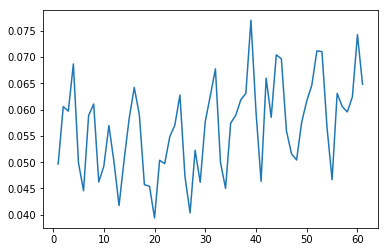

In [8]:
# trying to see pattern within 60 days
plt.plot(df.groupby(['day'])['demand'].mean())

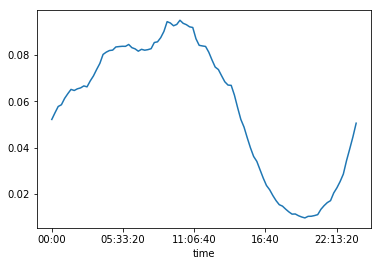

In [9]:
# trying to see pattern within a day
plt.plot(df.groupby(['timestamp'])['demand'].mean())

Two observations here:
1. There is a pattern between weekdays and weekends, so let's use the modulus 7 to identify which day it is in a week as one of the features although such information is not given in the original database.
2. Another pattern within a day with peak around 10am (morning rush hour) and low point around 8pm (during dinnertime - not sure why?)

In [10]:
# applying modulus 7
daykeys = df.day.unique()
dayvalues = daykeys % 7
daydict = dict(zip(daykeys, dayvalues))
df['day_'] = df['day'].map(daydict)

df.head()

,geohash6,day,timestamp,demand,day_
"(qp02yc, 1, 00:00:00)",qp02yc,1,00:00:00,0.0,1
"(qp02yc, 1, 00:15:00)",qp02yc,1,00:15:00,0.0,1
"(qp02yc, 1, 00:30:00)",qp02yc,1,00:30:00,0.0,1
"(qp02yc, 1, 00:45:00)",qp02yc,1,00:45:00,0.0,1
"(qp02yc, 1, 01:00:00)",qp02yc,1,01:00:00,0.0,1


# Feature 1: Groupby Means

There are 3 groups of categorical variables here: day_, timestamp and geohash6. Instead of using one hot encoding, let's use groupby mean as features instead. The mean will act as an 'anchor' so that prediction values does not deviate too much from historical values.

In [11]:
meanday = dict(df.groupby('day_')['demand'].mean())
meantime = dict(df.groupby('timestamp')['demand'].mean())
meangeo = dict(df.groupby('geohash6')['demand'].mean())

df['meanday'] = df.day_.map(meanday)
df['meantime'] = df.timestamp.map(meantime)
df['meangeo'] = df.geohash6.map(meangeo)

In [12]:
df.head()

,geohash6,day,timestamp,demand,day_,meanday,meantime,meangeo
"(qp02yc, 1, 00:00:00)",qp02yc,1,00:00:00,0.0,1,0.056065,0.052137,0.002261
"(qp02yc, 1, 00:15:00)",qp02yc,1,00:15:00,0.0,1,0.056065,0.055022,0.002261
"(qp02yc, 1, 00:30:00)",qp02yc,1,00:30:00,0.0,1,0.056065,0.057736,0.002261
"(qp02yc, 1, 00:45:00)",qp02yc,1,00:45:00,0.0,1,0.056065,0.058483,0.002261
"(qp02yc, 1, 01:00:00)",qp02yc,1,01:00:00,0.0,1,0.056065,0.061226,0.002261


# Feature 2: Geocorrelation (neighbordemand)

I hypothesize that demands among areas that are close/clustered to each other are correlated. In other words, demand in an area is correlated to demands in their close neighbors. So let's apply inverse distance weighting function (IDW), which is a weighted average based on the inverse distance value on the demand. I call this feature "neighbordemand".

In [13]:
#neighbor demand

def distance(originlats, originlons, destlats, destlons):
    
    radius = 6371 # km
    
    dlat = (destlats - originlats).map(math.radians)
    dlon = (destlons - originlons).map(math.radians)
    
    a = (dlat/2).map(math.sin) * (dlat/2).map(math.sin) + originlats.map(math.radians).map(math.cos) * destlats.map(math.radians).map(math.cos) * (dlon/2).map(math.sin) * (dlon/2).map(math.sin)
    c = pd.Series(2 * np.vectorize(math.atan2)(a.map(math.sqrt), (1-a).map(math.sqrt)))
    d = radius * c

    return d

geokeys = np.sort(df.geohash6.unique())
decoder = lambda x: decode(x)
geovalues = list(map(decoder,geokeys))

geo_ = pd.DataFrame(list(product(geovalues,geovalues)),columns=['origin','destination'])
temp = pd.DataFrame(geo_.origin.tolist(), columns=['originlats','originlons'], index=geo_.index, dtype=float)
geo_ = geo_.merge(temp,left_index=True,right_index=True)
temp = pd.DataFrame(geo_.destination.tolist(), columns=['destlats','destlons'], index=geo_.index, dtype=float)
geo_ = geo_.merge(temp,left_index=True,right_index=True)
geo_ = geo_.drop(columns=['origin','destination'])

geo_['distance'] = distance(geo_.originlats,geo_.originlons,geo_.destlats,geo_.destlons)
geomatrix = pd.DataFrame(geo_['distance'].values.reshape(len(geovalues),len(geovalues)), index=geokeys, columns=geokeys)
geomatrix = geomatrix.applymap(lambda x: x**np.pi) # one of hyperparameters that can be tuned
geomatrix = geomatrix.applymap(np.reciprocal)
geomatrix = geomatrix.replace(np.inf,1)
np.fill_diagonal(geomatrix.values, 0)
geomatrix_ = geomatrix.values

days = np.sort(df.day.unique())
times = np.sort(df.timestamp.unique())

demandmatrix = df.demand.values.reshape(len(geokeys),len(days)*len(times)).T
demandmatrix_ = demandmatrix @ geomatrix_
df['neighbordemand'] = demandmatrix_.T.flatten().astype(np.float32)

neighborscaler = MinMaxScaler()
neighborscaler = neighborscaler.fit(df['neighbordemand'].values.reshape(-1, 1))
df['neighbordemand'] = neighborscaler.transform(df['neighbordemand'].values.reshape(-1, 1))

C:\Users\Andy\Anaconda3\envs\py3\lib\site-packages\pandas\core\frame.py:6551: RuntimeWarning: divide by zero encountered in reciprocal
  return lib.map_infer(x.astype(object).values, func)


In [14]:
df.head()

,geohash6,day,timestamp,demand,day_,meanday,meantime,meangeo,neighbordemand
"(qp02yc, 1, 00:00:00)",qp02yc,1,00:00:00,0.0,1,0.056065,0.052137,0.002261,0.001854
"(qp02yc, 1, 00:15:00)",qp02yc,1,00:15:00,0.0,1,0.056065,0.055022,0.002261,0.003198
"(qp02yc, 1, 00:30:00)",qp02yc,1,00:30:00,0.0,1,0.056065,0.057736,0.002261,0.004232
"(qp02yc, 1, 00:45:00)",qp02yc,1,00:45:00,0.0,1,0.056065,0.058483,0.002261,0.005933
"(qp02yc, 1, 01:00:00)",qp02yc,1,01:00:00,0.0,1,0.056065,0.061226,0.002261,0.012483


# Feature 3: Sampling historical data

At this point, I am tempted to model using sequence-to-sequence LSTM, but I feel like sampling at relevant time points would yield better prediction compared to feeding raw sequences into the LSTM model. For my model, I will sample at these time points:
1. D-0 (today): T-5 to T-0 (now)
2. D-1 (yesterday): T-5 to T-0 (exactly the same time yesterday) to T+5
3. D-7 (last week): T-5 to T-0 (exactly the same time last week) to T+5

We want to predict D-0 at time points T-1 to T-5 as specified in the problem statement.

To avoid confusion, I will rename the column names as follows:
1. demand: d_d-0_t-0
2. neighbordemand: nd_d-0_t-0

Other variables will follow the above naming conventions. For example neighbor demand last week at T+3 will have the variable 'nd_d-7_t+3'

In [15]:
df.rename(columns={'demand':'d_d-0_t-0','neighbordemand':'nd_d-0_t-0'},inplace=True)

for i in ['d','nd']:
    for j in list(range(1,6)):
        columnname = i + '_d-0_t' + str(-j)
        df[columnname] = np.where(df.geohash6==df.geohash6.shift(j),df[i + '_d-0_t-0'].shift(j),np.nan)
    for j in list(range(-5,6)):
        columnname = i + '_d-1_t' + str(-j)
        df[columnname] = np.where(df.geohash6==df.geohash6.shift(j+96),df[i + '_d-0_t-0'].shift(j+96),np.nan)
    for j in list(range(-5,6)):
        columnname = i + '_d-7_t' + str(-j)
        df[columnname] = np.where(df.geohash6==df.geohash6.shift(j+(96*7)),df[i + '_d-0_t-0'].shift(j+(96*7)),np.nan)

for j in list(range(-5,0)):
    columnname = 'T' + str(-j)
    df[columnname] = np.where(df.geohash6==df.geohash6.shift(j),df['d_d-0_t-0'].shift(j),np.nan)

In [16]:
df.head()

,geohash6,day,timestamp,d_d-0_t-0,day_,meanday,meantime,meangeo,nd_d-0_t-0,d_d-0_t-1,...,nd_d-7_t-1,nd_d-7_t-2,nd_d-7_t-3,nd_d-7_t-4,nd_d-7_t-5,T5,T4,T3,T2,T1
"(qp02yc, 1, 00:00:00)",qp02yc,1,00:00:00,0.0,1,0.056065,0.052137,0.002261,0.001854,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
"(qp02yc, 1, 00:15:00)",qp02yc,1,00:15:00,0.0,1,0.056065,0.055022,0.002261,0.003198,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
"(qp02yc, 1, 00:30:00)",qp02yc,1,00:30:00,0.0,1,0.056065,0.057736,0.002261,0.004232,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
"(qp02yc, 1, 00:45:00)",qp02yc,1,00:45:00,0.0,1,0.056065,0.058483,0.002261,0.005933,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
"(qp02yc, 1, 01:00:00)",qp02yc,1,01:00:00,0.0,1,0.056065,0.061226,0.002261,0.012483,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


Now we can drop the NaN values and drop the unused columns. We split the dataframe into X (features) and y (labels). Finally, we split the data into train and test datasets.

In [17]:
df = df.dropna()
df = df.drop(columns=['geohash6','day','timestamp','day_'])


y = pd.DataFrame()
y['T1'],y['T2'],y['T3'],y['T4'],y['T5'] = df['T1'],df['T2'],df['T3'],df['T4'],df['T5']
X = df.drop(columns=['T1','T2','T3','T4','T5'])
del df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Modelling

For the modelling, we will use a simple 2-layer neural network so that it will run at a reasonable speed. I assume that if we scale this to larger datasets, speed is at utmost importance as we are streaming data at real time during deployment phase. First, we will set the parameters and the functions used in the modelling.

In [18]:
parameters = {
        'dropout' : 0.5,
        'epoch' : 10,
        'batch_size' : 512}

def dense(X_train, X_test, y_train, y_test, parameters):
    main_input = keras.Input(shape=(X_train.shape[1],), name='main_input')
    
    normx1 = keras.layers.normalization.BatchNormalization() (main_input)
    encoder1 = keras.layers.Dense(64,kernel_initializer='glorot_normal', activation='selu')(normx1)
    dropencoder1 = keras.layers.core.Dropout(rate = parameters['dropout'])(encoder1)
    encoder2 = keras.layers.Dense(64,kernel_initializer='glorot_normal', activation='selu')(dropencoder1)
    dropencoder2 = keras.layers.core.Dropout(rate = parameters['dropout'])(encoder2)
    normdecoder = keras.layers.normalization.BatchNormalization() (dropencoder2)
    
    main_output = keras.layers.Dense(5, activation='linear', name='main_output')(normdecoder)
    
    model = keras.models.Model(inputs=main_input, outputs=main_output)
    
    return model

def fulltraining(model, X_train, X_test, y_train, y_test, parameters):
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1)
    
    model.compile(optimizer='nadam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # fit network
    history = model.fit({'main_input': X_train}, y_train, epochs=parameters['epoch'], batch_size=parameters['batch_size'], validation_data=({'main_input': X_test}, y_test), verbose=1, callbacks=[reduce_lr], shuffle=False)
    # plot history
    #plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    return model

def save_model(model):
    model.save_weights('grab.h5')

def load_model(model):
    model.load_weights('grab.h5')

In [19]:
model = dense(X_train, X_test, y_train, y_test, parameters)
#model = fulltraining(model, X_train, X_test, y_train, y_test, parameters)
model.load_weights('grab.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Finally, let's predict using our model.

In [20]:
def predict(model):
    # make a prediction
    
    predraw = model.predict({'main_input': X_test})
    pred = pd.DataFrame(predraw, columns=['T1','T2','T3','T4','T5'])
    return pred

In [21]:
pred = predict(model)
pred.index = y_test.index

In [22]:
y_test = y_test.sort_index()
pred = pred.sort_index()
y_test['geohash6'],y_test['day'],y_test['timestamp'] = zip(*y_test.index)
pred['geohash6'],pred['day'],pred['timestamp'] = zip(*pred.index)

Let's us check the RMSE of the predictions

In [23]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [24]:
rmset1 = rmse(pred['T1'],y_test['T1'])
rmset2 = rmse(pred['T2'],y_test['T2'])
rmset3 = rmse(pred['T3'],y_test['T3'])
rmset4 = rmse(pred['T4'],y_test['T4'])
rmset5 = rmse(pred['T5'],y_test['T5'])
predall = pd.Series()
predall = predall.append([pred['T1'],pred['T2'],pred['T3'],pred['T4'],pred['T5']])
y_testall = pd.Series()
y_testall = y_testall.append([y_test['T1'],y_test['T2'],y_test['T3'],y_test['T4'],y_test['T5']])
rmsetall = rmse(predall,y_testall)

In [25]:
print('RMSE at T1: ', rmset1)
print('RMSE at T2: ', rmset2)
print('RMSE at T3: ', rmset3)
print('RMSE at T4: ', rmset4)
print('RMSE at T5: ', rmset5)
print('RMSE at T1 to T5: ', rmsetall)

RMSE at T1:  0.02368799227648709
RMSE at T2:  0.026668600694302345
RMSE at T3:  0.028684248732614017
RMSE at T4:  0.030547229666919286
RMSE at T5:  0.032673359303460436
RMSE at T1 to T5:  0.028509102689443358


So on average RMSE is around 0.02 to 0.03 and we're done with model.